# Heads-Up

In the notebook, we are working on generating
graphs whose nodes have Euclidean coordinates;
One thing to pay attention to is, in real world
road network, nodes (intersections) that are close
to each other geographically are more likely to be
connected with edges (roads).

Edge centrality will be added as part of the heuristic;
meantime, cosine distance can also be a good heuristic;
The geographical coordinates of nodes can be included.

# Questions

Does centrality really encode information about your destination?

# Think with Analogy

The model should not look back;
The graph used for training is small and
the trained model is used to infer nodes on
similar sized graphs; perhaps training with
big graphs will lead to better inference
on smaller graphs

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score
from utils import plot_g

In [2]:
NUM_NODE = 100
WEIGHT_MIN = .0
WEIGHT_MAX = 1.

In [3]:
def calc_euclidean_dist(G, tmp_node, node):
    
    p_1 = np.array([G.nodes[tmp_node]['x'], G.nodes[tmp_node]['y']])
    p_2 = np.array([G.nodes[node]['x'], G.nodes[node]['y']])
    return np.sqrt(np.sum((p_1 - p_2)**2))

def generate_low_degree_g(node_size=20, min_out_degree=2, max_out_degree=4, weight_min=WEIGHT_MIN, weight_max=WEIGHT_MAX):
    
    G = nx.Graph()
    
    grid_size = 1000
    euclidean_coords = np.linspace(0.01, 1.0, num=grid_size, endpoint=False)
    coords_indices = list(range(grid_size))
    
    random.shuffle(coords_indices)
    x_coords = euclidean_coords[coords_indices][:node_size]
#     print(x_coords)
    random.shuffle(coords_indices)
    y_coords = euclidean_coords[coords_indices][:node_size]
#     print(y_coords)
    
    # Add coordinates to nodes
    for node, coord in enumerate(zip(x_coords, y_coords)):
#         print(node, coord[0], coord[1])
        G.add_node(node, x=coord[0], y=coord[1])
    
    for node in G.nodes:
        
        tmp_nodes = list(G.nodes)
        tmp_nodes.remove(node)
        node_dist = map(lambda tmp_node: (tmp_node, calc_euclidean_dist(G, tmp_node, node)), tmp_nodes)
        node_dist = sorted(node_dist, key=lambda d:d[1])
        
        num_of_neighbors = random.randint(min_out_degree, max_out_degree)
#         print(node, out_neighbors)
        
#         G.add_edges_from(map(lambda d:(node, d), out_neighbors))
        
        for tmp_node in node_dist:

            if G.degree(tmp_node[0]) >= max_out_degree \
                or G.degree(node) >= num_of_neighbors:
                # This node has maximum number of neighbors already
                continue
            
            weight = random.uniform(weight_min, weight_max)
            G.add_edge(node, tmp_node[0], weight=weight)
    
    # Add centrality to edges
    edge_centrality = nx.edge_betweenness_centrality(G, \
                                                     k=G.number_of_nodes(), \
                                                     weight='weight')
    assert len(edge_centrality) == G.number_of_edges()
    
    for edge_data in G.edges.data():
        edge_data[2]['centrality'] = edge_centrality[(edge_data[0], edge_data[1])]
        
    return G

4
2
20
33


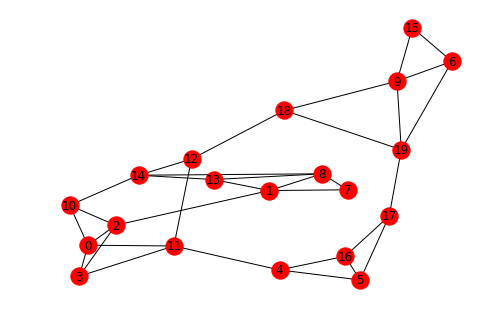

In [68]:
G = generate_low_degree_g()
max_degree = max(G.degree, key=lambda d: d[1])[1]
min_degree = min(G.degree, key=lambda d: d[1])[1]
print(max_degree)
print(min_degree)
print(G.number_of_nodes())
print(G.number_of_edges())
plot_g(G)

In [6]:
def calc_cosine_dist(p1, p2):
    return np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))

def encode_edges(G, node, dst):
    
    ret = np.zeros((max_degree, 6))
    ret[:, -1] = -1
    
    for idx, edge in enumerate(G.edges(node)):
        u = edge[0]
        v = edge[1]
        
        ret[idx][0] = G.get_edge_data(u, v)['centrality']
        ret[idx][1] = G.get_edge_data(u, v)['weight']
        
        x_u = G.nodes[u]['x']
        y_u = G.nodes[u]['y']
        x_v = G.nodes[v]['x']
        y_v = G.nodes[v]['y']
        x_dst = G.nodes[dst]['x']
        y_dst = G.nodes[dst]['y']
        
        ret[idx][2] = calc_cosine_dist((x_v-x_u, y_v-y_u), (x_dst-x_u, y_dst-y_u))
        ret[idx][3] = x_v
        ret[idx][4] = y_v
        ret[idx][-1] = v
        
    return (ret, x_dst, y_dst)

def generate_dataset(G):
    
    X = []
    y = []

    for paths in nx.all_pairs_dijkstra_path(G):

        print("src :%d" % paths[0])
        print(paths[1])
        print('')
        src = paths[0]

        for dst, path in paths[1].items():

            if dst == src:
                continue

            # X = cur_node + dst_node
            # y = next_node (Dijkstra)

            cur_node = src
            for mid_node in path[1:]:

                print('X:(%d, %d), y:(%d)' % (cur_node, dst, mid_node))
                X.append(encode_edges(G, cur_node, dst))
                y.append(mid_node)

                cur_node = mid_node

    #         print(cur_node, dst)
            print(path)
            print('')
    
    return X, y

In [7]:
features, labels = generate_dataset(G)

src :0
{0: [0], 1: [0, 13, 11, 19, 1], 2: [0, 13, 11, 19, 1, 2], 3: [0, 13, 11, 19, 1, 10, 12, 3], 4: [0, 13, 6, 7, 4], 5: [0, 13, 5], 6: [0, 13, 6], 7: [0, 13, 6, 7], 8: [0, 13, 11, 19, 16, 17, 8], 9: [0, 13, 11, 19, 1, 9], 10: [0, 13, 11, 19, 1, 10], 11: [0, 13, 11], 12: [0, 13, 11, 19, 1, 10, 12], 13: [0, 13], 14: [0, 13, 11, 19, 1, 10, 12, 14], 15: [0, 15], 16: [0, 13, 11, 19, 16], 17: [0, 13, 11, 19, 16, 17], 18: [0, 13, 6, 18], 19: [0, 13, 11, 19]}

X:(0, 1), y:(13)
X:(13, 1), y:(11)
X:(11, 1), y:(19)
X:(19, 1), y:(1)
[0, 13, 11, 19, 1]

X:(0, 2), y:(13)
X:(13, 2), y:(11)
X:(11, 2), y:(19)
X:(19, 2), y:(1)
X:(1, 2), y:(2)
[0, 13, 11, 19, 1, 2]

X:(0, 3), y:(13)
X:(13, 3), y:(11)
X:(11, 3), y:(19)
X:(19, 3), y:(1)
X:(1, 3), y:(10)
X:(10, 3), y:(12)
X:(12, 3), y:(3)
[0, 13, 11, 19, 1, 10, 12, 3]

X:(0, 4), y:(13)
X:(13, 4), y:(6)
X:(6, 4), y:(7)
X:(7, 4), y:(4)
[0, 13, 6, 7, 4]

X:(0, 5), y:(13)
X:(13, 5), y:(5)
[0, 13, 5]

X:(0, 6), y:(13)
X:(13, 6), y:(6)
[0, 13, 6]

X:(0, 7), y:

X:(11, 2), y:(19)
X:(19, 2), y:(1)
X:(1, 2), y:(2)
[4, 7, 11, 19, 1, 2]

X:(4, 3), y:(7)
X:(7, 3), y:(11)
X:(11, 3), y:(19)
X:(19, 3), y:(1)
X:(1, 3), y:(10)
X:(10, 3), y:(12)
X:(12, 3), y:(3)
[4, 7, 11, 19, 1, 10, 12, 3]

X:(4, 5), y:(7)
X:(7, 5), y:(6)
X:(6, 5), y:(13)
X:(13, 5), y:(5)
[4, 7, 6, 13, 5]

X:(4, 6), y:(7)
X:(7, 6), y:(6)
[4, 7, 6]

X:(4, 7), y:(7)
[4, 7]

X:(4, 8), y:(7)
X:(7, 8), y:(11)
X:(11, 8), y:(19)
X:(19, 8), y:(16)
X:(16, 8), y:(17)
X:(17, 8), y:(8)
[4, 7, 11, 19, 16, 17, 8]

X:(4, 9), y:(7)
X:(7, 9), y:(11)
X:(11, 9), y:(19)
X:(19, 9), y:(1)
X:(1, 9), y:(9)
[4, 7, 11, 19, 1, 9]

X:(4, 10), y:(7)
X:(7, 10), y:(11)
X:(11, 10), y:(19)
X:(19, 10), y:(1)
X:(1, 10), y:(10)
[4, 7, 11, 19, 1, 10]

X:(4, 11), y:(7)
X:(7, 11), y:(11)
[4, 7, 11]

X:(4, 12), y:(7)
X:(7, 12), y:(11)
X:(11, 12), y:(19)
X:(19, 12), y:(1)
X:(1, 12), y:(10)
X:(10, 12), y:(12)
[4, 7, 11, 19, 1, 10, 12]

X:(4, 13), y:(7)
X:(7, 13), y:(6)
X:(6, 13), y:(13)
[4, 7, 6, 13]

X:(4, 14), y:(7)
X:(7, 14)

X:(11, 5), y:(13)
X:(13, 5), y:(5)
[8, 17, 16, 19, 11, 13, 5]

X:(8, 6), y:(17)
X:(17, 6), y:(16)
X:(16, 6), y:(19)
X:(19, 6), y:(11)
X:(11, 6), y:(13)
X:(13, 6), y:(6)
[8, 17, 16, 19, 11, 13, 6]

X:(8, 7), y:(17)
X:(17, 7), y:(16)
X:(16, 7), y:(19)
X:(19, 7), y:(11)
X:(11, 7), y:(7)
[8, 17, 16, 19, 11, 7]

X:(8, 9), y:(3)
X:(3, 9), y:(12)
X:(12, 9), y:(10)
X:(10, 9), y:(9)
[8, 3, 12, 10, 9]

X:(8, 10), y:(3)
X:(3, 10), y:(12)
X:(12, 10), y:(10)
[8, 3, 12, 10]

X:(8, 11), y:(17)
X:(17, 11), y:(16)
X:(16, 11), y:(19)
X:(19, 11), y:(11)
[8, 17, 16, 19, 11]

X:(8, 12), y:(3)
X:(3, 12), y:(12)
[8, 3, 12]

X:(8, 13), y:(17)
X:(17, 13), y:(16)
X:(16, 13), y:(19)
X:(19, 13), y:(11)
X:(11, 13), y:(13)
[8, 17, 16, 19, 11, 13]

X:(8, 14), y:(14)
[8, 14]

X:(8, 15), y:(17)
X:(17, 15), y:(16)
X:(16, 15), y:(19)
X:(19, 15), y:(11)
X:(11, 15), y:(13)
X:(13, 15), y:(0)
X:(0, 15), y:(15)
[8, 17, 16, 19, 11, 13, 0, 15]

X:(8, 16), y:(17)
X:(17, 16), y:(16)
[8, 17, 16]

X:(8, 17), y:(17)
[8, 17]

X:(8, 

X:(1, 18), y:(19)
X:(19, 18), y:(11)
X:(11, 18), y:(13)
X:(13, 18), y:(6)
X:(6, 18), y:(18)
[12, 10, 1, 19, 11, 13, 6, 18]

X:(12, 19), y:(10)
X:(10, 19), y:(1)
X:(1, 19), y:(19)
[12, 10, 1, 19]

src :13
{0: [13, 0], 1: [13, 11, 19, 1], 2: [13, 11, 19, 1, 2], 3: [13, 11, 19, 1, 10, 12, 3], 4: [13, 6, 7, 4], 5: [13, 5], 6: [13, 6], 7: [13, 6, 7], 8: [13, 11, 19, 16, 17, 8], 9: [13, 11, 19, 1, 9], 10: [13, 11, 19, 1, 10], 11: [13, 11], 12: [13, 11, 19, 1, 10, 12], 13: [13], 14: [13, 11, 19, 1, 10, 12, 14], 15: [13, 0, 15], 16: [13, 11, 19, 16], 17: [13, 11, 19, 16, 17], 18: [13, 6, 18], 19: [13, 11, 19]}

X:(13, 0), y:(0)
[13, 0]

X:(13, 1), y:(11)
X:(11, 1), y:(19)
X:(19, 1), y:(1)
[13, 11, 19, 1]

X:(13, 2), y:(11)
X:(11, 2), y:(19)
X:(19, 2), y:(1)
X:(1, 2), y:(2)
[13, 11, 19, 1, 2]

X:(13, 3), y:(11)
X:(11, 3), y:(19)
X:(19, 3), y:(1)
X:(1, 3), y:(10)
X:(10, 3), y:(12)
X:(12, 3), y:(3)
[13, 11, 19, 1, 10, 12, 3]

X:(13, 4), y:(6)
X:(6, 4), y:(7)
X:(7, 4), y:(4)
[13, 6, 7, 4]

X:(13, 

X:(13, 18), y:(6)
X:(6, 18), y:(18)
[16, 19, 11, 13, 6, 18]

X:(16, 19), y:(19)
[16, 19]

src :17
{0: [17, 16, 19, 11, 13, 0], 1: [17, 8, 3, 12, 10, 1], 2: [17, 8, 3, 12, 10, 1, 2], 3: [17, 8, 3], 4: [17, 16, 19, 11, 7, 4], 5: [17, 16, 19, 11, 13, 5], 6: [17, 16, 19, 11, 13, 6], 7: [17, 16, 19, 11, 7], 8: [17, 8], 9: [17, 8, 3, 12, 10, 9], 10: [17, 8, 3, 12, 10], 11: [17, 16, 19, 11], 12: [17, 8, 3, 12], 13: [17, 16, 19, 11, 13], 14: [17, 8, 14], 15: [17, 16, 19, 11, 13, 0, 15], 16: [17, 16], 17: [17], 18: [17, 16, 19, 11, 13, 6, 18], 19: [17, 16, 19]}

X:(17, 0), y:(16)
X:(16, 0), y:(19)
X:(19, 0), y:(11)
X:(11, 0), y:(13)
X:(13, 0), y:(0)
[17, 16, 19, 11, 13, 0]

X:(17, 1), y:(8)
X:(8, 1), y:(3)
X:(3, 1), y:(12)
X:(12, 1), y:(10)
X:(10, 1), y:(1)
[17, 8, 3, 12, 10, 1]

X:(17, 2), y:(8)
X:(8, 2), y:(3)
X:(3, 2), y:(12)
X:(12, 2), y:(10)
X:(10, 2), y:(1)
X:(1, 2), y:(2)
[17, 8, 3, 12, 10, 1, 2]

X:(17, 3), y:(8)
X:(8, 3), y:(3)
[17, 8, 3]

X:(17, 4), y:(16)
X:(16, 4), y:(19)
X:(19, 4),

In [27]:
def find_label_idx(feature, label):
    
    for idx, row in enumerate(feature):
        if label == row[-1]:
            break
    
    return idx

def one_hot_encode(idx, length=max_degree):
    
    ret = np.zeros(length)
    ret[idx] = 1.0
    return ret

def augment_dataset(X, y, augmentation_index=20):
    
    X_aug, y_aug = [], []
    indices = np.arange(max_degree)
    
    for feature, label in zip(X, y):
        for _ in range(augmentation_index):
            np.random.shuffle(indices)
            
            feature_tmp = feature[0][indices]
            label_tmp = find_label_idx(feature_tmp, label)
            X_aug.append(np.append(feature_tmp[:, :-1].reshape(-1), [feature[1], feature[2]]))
            y_aug.append(one_hot_encode(label_tmp))
            
    return np.array(X_aug), np.array(y_aug)

In [28]:
X, y = augment_dataset(features, labels)

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, test_size=.15, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(24072, 22)
(24072, 4)
(4248, 22)
(4248, 4)


In [30]:
batch_size = 100

train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_test, y_test, batch_size=len(y_test))

In [32]:
def build_model(context=mx.gpu()):
    
    data = mx.sym.var('data')
    label = mx.sym.var('softmax_label')
    
    fc1  = mx.sym.FullyConnected(data=data, num_hidden=64)
    fc1 = mx.sym.Activation(data=fc1, act_type="relu")
    
    fc2  = mx.sym.FullyConnected(data=fc1, num_hidden=32)
    fc2 = mx.sym.Activation(data=fc2, act_type="relu")
    
    fc3  = mx.sym.FullyConnected(data=fc2, num_hidden=max_degree)
    mlp  = mx.sym.SoftmaxOutput(data=fc3, label=label)
    
    return mx.mod.Module(symbol=mlp, context=context)

def custom_acc(label, pred):
    tmp_label = np.argmax(label, axis=1)
    tmp_pred = np.argmax(pred, axis=1)
    return accuracy_score(tmp_label, tmp_pred)

In [37]:
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
model = build_model()
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params()

custom_metric = mx.metric.create(custom_acc)

In [43]:
model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='adam',  # use SGD to train
#               optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
              eval_metric=custom_metric,  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 10), # output progress for each 100 data batches
              num_epoch=10)  # train for at most 10 dataset passes

INFO:root:Epoch[0] Batch [10]	Speed: 108377.15 samples/sec	custom_acc=0.960000
INFO:root:Epoch[0] Batch [20]	Speed: 107216.36 samples/sec	custom_acc=0.971000
INFO:root:Epoch[0] Batch [30]	Speed: 105564.88 samples/sec	custom_acc=0.970000
INFO:root:Epoch[0] Batch [40]	Speed: 107008.47 samples/sec	custom_acc=0.967000
INFO:root:Epoch[0] Batch [50]	Speed: 107955.94 samples/sec	custom_acc=0.956000
INFO:root:Epoch[0] Batch [60]	Speed: 111222.30 samples/sec	custom_acc=0.962000
INFO:root:Epoch[0] Batch [70]	Speed: 106611.36 samples/sec	custom_acc=0.950000
INFO:root:Epoch[0] Batch [80]	Speed: 111630.80 samples/sec	custom_acc=0.962000
INFO:root:Epoch[0] Batch [90]	Speed: 112372.51 samples/sec	custom_acc=0.968000
INFO:root:Epoch[0] Batch [100]	Speed: 108954.28 samples/sec	custom_acc=0.974000
INFO:root:Epoch[0] Batch [110]	Speed: 110460.72 samples/sec	custom_acc=0.955000
INFO:root:Epoch[0] Batch [120]	Speed: 110731.93 samples/sec	custom_acc=0.970000
INFO:root:Epoch[0] Batch [130]	Speed: 108860.96 s

INFO:root:Epoch[4] Batch [10]	Speed: 111770.61 samples/sec	custom_acc=0.979091
INFO:root:Epoch[4] Batch [20]	Speed: 107216.36 samples/sec	custom_acc=0.973000
INFO:root:Epoch[4] Batch [30]	Speed: 104447.64 samples/sec	custom_acc=0.968000
INFO:root:Epoch[4] Batch [40]	Speed: 107606.96 samples/sec	custom_acc=0.978000
INFO:root:Epoch[4] Batch [50]	Speed: 107123.26 samples/sec	custom_acc=0.966000
INFO:root:Epoch[4] Batch [60]	Speed: 109360.52 samples/sec	custom_acc=0.961000
INFO:root:Epoch[4] Batch [70]	Speed: 109735.34 samples/sec	custom_acc=0.959000
INFO:root:Epoch[4] Batch [80]	Speed: 105252.30 samples/sec	custom_acc=0.954000
INFO:root:Epoch[4] Batch [90]	Speed: 106551.77 samples/sec	custom_acc=0.952000
INFO:root:Epoch[4] Batch [100]	Speed: 106926.63 samples/sec	custom_acc=0.969000
INFO:root:Epoch[4] Batch [110]	Speed: 106814.98 samples/sec	custom_acc=0.961000
INFO:root:Epoch[4] Batch [120]	Speed: 113276.91 samples/sec	custom_acc=0.977000
INFO:root:Epoch[4] Batch [130]	Speed: 106926.63 s

INFO:root:Epoch[8] Batch [30]	Speed: 106147.29 samples/sec	custom_acc=0.972000
INFO:root:Epoch[8] Batch [40]	Speed: 108542.62 samples/sec	custom_acc=0.974000
INFO:root:Epoch[8] Batch [50]	Speed: 97162.34 samples/sec	custom_acc=0.976000
INFO:root:Epoch[8] Batch [60]	Speed: 107549.01 samples/sec	custom_acc=0.970000
INFO:root:Epoch[8] Batch [70]	Speed: 107375.56 samples/sec	custom_acc=0.967000
INFO:root:Epoch[8] Batch [80]	Speed: 104755.46 samples/sec	custom_acc=0.974000
INFO:root:Epoch[8] Batch [90]	Speed: 108131.27 samples/sec	custom_acc=0.975000
INFO:root:Epoch[8] Batch [100]	Speed: 111133.89 samples/sec	custom_acc=0.979000
INFO:root:Epoch[8] Batch [110]	Speed: 105418.96 samples/sec	custom_acc=0.967000
INFO:root:Epoch[8] Batch [120]	Speed: 96600.66 samples/sec	custom_acc=0.974000
INFO:root:Epoch[8] Batch [130]	Speed: 105464.02 samples/sec	custom_acc=0.981000
INFO:root:Epoch[8] Batch [140]	Speed: 108259.66 samples/sec	custom_acc=0.965000
INFO:root:Epoch[8] Batch [150]	Speed: 101429.29 s

In [44]:
pred_train = np.argmax(model.predict(mx.io.NDArrayIter(X_train, y_train, batch_size=len(y_train))).asnumpy(), axis=1)
print('Acc on training set %f' % accuracy_score(np.argmax(y_train, axis=1), pred_train))

pred_test = np.argmax(model.predict(mx.io.NDArrayIter(X_test, y_test, batch_size=len(y_test))).asnumpy(), axis=1)
print('Acc on test set %f' % accuracy_score(np.argmax(y_test, axis=1), pred_test))

Acc on training set 0.977817
Acc on test set 0.972458


In [49]:
def nn_infer_next_node(G, cur_node, dst, model):
#     print("In nn_infer_next_node")
    input_vec = np.zeros((max_degree, 6))
    input_vec[:, -1] = -1
    
    x_dst = G.nodes[dst]['x']
    y_dst = G.nodes[dst]['y']
    
    for idx, edge in enumerate(G.edges(cur_node)):
        u = edge[0]
        v = edge[1]
        
        input_vec[idx][0] = G.get_edge_data(u, v)['centrality']
        input_vec[idx][1] = G.get_edge_data(u, v)['weight']
        
        x_u = G.nodes[u]['x']
        y_u = G.nodes[u]['y']
        x_v = G.nodes[v]['x']
        y_v = G.nodes[v]['y']

        input_vec[idx][2] = calc_cosine_dist((x_v-x_u, y_v-y_u), (x_dst-x_u, y_dst-y_u))
        input_vec[idx][3] = x_v
        input_vec[idx][4] = y_v
        input_vec[idx][-1] = v
    
    real_input_vec = np.append(input_vec[:, :-1].reshape(-1), [x_dst, y_dst])
    pred_idx = np.argmax(model.predict(mx.io.NDArrayIter(np.array([real_input_vec]), np.array([0]))).asnumpy()[0])
    
    neighbor = input_vec[pred_idx][-1]
    return (int(neighbor), G.get_edge_data(cur_node, neighbor)['weight'])

def dijkstra_path_finder(G, src, dst, model=None):
    
    path = [src]
    cur_node = src
    total_weights = .0
    
    while True:
        
        if len(path) >= G.number_of_nodes():
            return path, total_weights, False
        
        next_node, weight = nn_infer_next_node(G, cur_node, dst, model)
        total_weights += weight
        path.append(next_node)
        
        if next_node == dst:
            return path, total_weights, True
        
        cur_node = next_node

In [80]:
G = generate_low_degree_g()

cnt = 0

for src in G.nodes():
    for dst in G.nodes():
        
        if src == dst:
            continue
        
        path, _, found = dijkstra_path_finder(G, src, dst, model=model)
        cnt = cnt + 1 if found else cnt

In [81]:
num_of_nodes = G.number_of_nodes()
num_total_path = num_of_nodes*(num_of_nodes-1)
print('%d out of %d can find path: %f' % (cnt, num_total_path, float(cnt)/num_total_path))  

254 out of 380 can find path: 0.668421
